In [1]:
%pylab inline
import numpy as np
import numpy.matlib
import random as rnd
import pandas as pd
from matplotlib import pylab

Populating the interactive namespace from numpy and matplotlib


In [2]:
def softmax(x):
    try:
        amax = np.max(x,axis=1)
        amax = np.outer(amax, np.ones(x.shape[1]))
        vect = np.exp(x-amax)
        vsum = np.outer(np.sum(vect,axis=1),np.ones(x.shape[1]))
    except:
        amax = np.max(x)
        vect = np.exp(x-amax)
        vsum = np.sum(vect)
        
    return vect/vsum

#à voir on pourrait offrir une implémentation plus jolie/robuste
def softmax_v2(x):
    amax = np.amax(np.transpose(x),axis=0)
    amax = np.matlib.repmat(amax,len(xd),1)
    vect = np.exp(x-amax)
    vsum = np.sum(x.T,axis=0)
    return vect/vsum

def rect(x):
    y = x.copy()
    y[np.where(y<0)]=0.
    return y

def gradRect(x):
    x[np.where(x>0)] = 1
    x[np.where(x<=0)]=0
    return x   

def oneHot(y):
    categories = np.unique(y)
    vect = np.zeros((len(y),len(categories))) #construction des vecteurs onehot de la bonne dimension
    for v in range(len(categories)): #parcours les categories
        vect[np.where(y==v),v]=1
    return vect
    
def normAbs(x):
    n = 0
    for i in x:
        n += abs(np.linalg.norm(i))
    return n    

In [4]:
class NeuralNet:
    def __init__(self,d,dh,m,nc=1,lam=np.array([[.1,.5],[.1,.5]])):
        self.nc = nc #le nombre de couches cachées
        self.dh = dh # Le nombre de neuronnes de la couche cachée
        self.d = d #la dimension du vecteur d'entree x
        self.m = m #la dimension de sortie
        self.lam = lam # la matrice des coefficients elastic net
        self.theta = np.zeros((d*dh+dh+dh*m+m))#le vecteur des parametres
        self.W1 = self.theta[0:d*dh].reshape(dh,d)
        self.b1 = self.theta[d*dh:d*dh+dh].reshape(dh,)
        self.W2 = self.theta[d*dh+dh:d*dh+dh+dh*m].reshape(m,dh)
        self.b2 = self.theta[d*dh+dh+dh*m:].reshape(m,)
        self.grad = np.ones((d*dh+dh+dh*m+m))
        
        #on init self.w1 a self.theta[0:d*dh].reshape(d,dh)
    def initialisation(self):
        self.theta[0:self.d*self.dh] = np.random.uniform(low=-1./np.sqrt(self.d),high=1./np.sqrt(self.d),size=(self.dh*self.d))
        self.theta[self.d*self.dh+self.dh:self.d*self.dh+self.dh+self.dh*self.m] = \
            np.random.uniform(low=-1./np.sqrt(self.dh),high=1./np.sqrt(self.dh),size=(self.m*self.dh))
        
    def fprop(self,x,y):
        self.h_a = np.dot(self.W1,x) + self.b1
        self.h_s = rect(self.h_a)
        self.o_a = np.dot(self.W2,self.h_s) + self.b2
        self.o_s = softmax(self.o_a)
        self.loss = -np.log(np.dot(self.o_s,y))
        
    def bprop(self,x,y):
        self.fprop(x,y)
        grad = []
        self.grad_oa = self.o_s-y
        self.grad_b2 = self.grad_oa
        self.grad_W2 = np.outer(self.grad_oa,self.h_s)

        self.grad_hs = np.dot(np.transpose(self.W2), self.grad_oa)
        self.grad_ha = self.grad_hs*gradRect(self.h_a)
        self.grad_b1 = self.grad_ha
        self.grad_W1 = np.outer(self.grad_ha,x)
        
        #Le gradient total dL/dtheta comme dans la partie theo du devoir
        self.grad = np.concatenate([np.concatenate(self.grad_W1),self.grad_b1, np.concatenate(self.grad_W2), self.grad_b2])
        
    def grad_diff_finies(self,f,l,k=1):
        epsi = 0.0001
        for m in range(k):
            if k == 1:
                x = f
                y = l
            else: 
                x = f[m]
                y = l[m]
            
            self.bprop(x,y)
            startVal = self.loss.copy()

            # Pour les param contenus dans W1
            self.diffFin_W1 = np.zeros((self.dh,self.d))
            for i in range(len(self.W1)):
                for j in range(len(self.W1[i])):
                    self.W1[i,j] += epsi
                    self.fprop(x,y)
                    self.diffFin_W1[i,j]= (self.loss - startVal)/epsi
                    self.W1[i,j] -= epsi
            print '\nVerification pour W1:'
            print np.round(self.diffFin_W1 - self.grad_W1,4)

            # Pour les param contenus dans W2
            self.diffFin_W2 = np.zeros((self.m,self.dh))
            for i in range(len(self.W2)):
                for j in range(len(self.W2[i])):
                    self.W2[i,j] += epsi
                    self.fprop(x,y)
                    self.diffFin_W2[i,j]= (self.loss - startVal)/epsi
                    self.W2[i,j] -= epsi
            print '\nVerification pour W2:'
            print np.round(self.diffFin_W2 - self.grad_W2,4)

            # Pour les param contenus dans b1
            self.diffFin_b1 = np.zeros(self.dh)
            for i in range(len(self.b1)):
                self.b1[i] +=epsi
                self.fprop(x,y)
                self.diffFin_b1[i]= (self.loss - startVal)/epsi
                self.b1[i] -= epsi
            print '\nVerification pour b1:'
            print np.round(self.diffFin_b1 - self.grad_b1,4)

            # Pour les param contenus dans b2
            self.diffFin_b2 = np.zeros(self.m)
            for i in range(len(self.b2)):
                self.b2[i] += epsi
                self.fprop(x,y)
                self.diffFin_b2[i]= (self.loss - startVal)/epsi
                self.b2[i] -= epsi
            print '\nVerification pour b2:'
            print np.round(self.diffFin_b2 - self.grad_b2,4)
            print '-----------------------------------------------'
    
    def train(self,x,y,L=.1,k=1,precision=0.001,max_iter=5000):
        xk = self.grad
        prev = xk+1.
        nbiter = 0
        while (np.linalg.norm(xk-prev) > precision) and (nbiter < max_iter):
            prev = xk.copy()
            nbiter +=1
            #on calcule le gradient
            if k == 1: #cas ou on entraine avec seulement 1 observation
                self.bprop(x,y)
                sum_grad = self.grad.copy()
                
            else: #on entraine avec plus de 1 observation
                sum_grad= np.zeros(self.grad.shape)
                for i in range(k):
                    self.bprop(x[i],y[i])
                    sum_grad += self.grad
                    
            #on modifie le gradient obtenue pour tenir compte de la normalisation Elastic Net
            norm_w1 = np.concatenate(self.lam[0,0] + self.lam[0,1]*self.W1)
            norm_w2 = np.concatenate(self.lam[1,0] + self.lam[1,1]*self.W2)
            sum_grad += np.concatenate([norm_w1,np.zeros(len(self.b1),),norm_w2,np.zeros(len(self.b2),)])
            
            self.theta -= L* (1./k)*sum_grad 
            xk = self.theta.copy()

        if nbiter == max_iter:
            print 'Arrêt causé par nombre d\'itérations'
        else:
            print 'Convergence, minimum possible après ' +str(nbiter)+' itérations.'   
    
    def train_mat(self,x,y,k=1,L=.1,precision=0.001,max_iter=5000,print_res = True):
        xk = self.grad
        prev = xk+1.
        nbiter = 0
        while (np.linalg.norm(xk-prev) > precision) and (nbiter < max_iter):
            prev = xk.copy()
            nbiter +=1
            # calcule bprop qui appelle frprop avent de calculer le gradient par back prop
            self.bprop_mat(x,y,k)
            #stock le gradient pour ce lot
            sum_grad = self.grad.copy()
            #on modifie le gradient obtenue pour tenir compte de la normalisation Elastic Net
            norm_w1 = np.concatenate(self.lam[0,0] + self.lam[0,1]*self.W1)
            norm_w2 = np.concatenate(self.lam[1,0] + self.lam[1,1]*self.W2)
            sum_grad += np.concatenate([norm_w1,np.zeros(len(self.b1),),norm_w2,np.zeros(len(self.b2),)])

            self.theta -= L* (1./k)*sum_grad 
            xk = self.theta.copy()
        
        if print_res:
            if nbiter == max_iter:
                print 'Arrêt causé par nombre d\'itérations'
            else:
                print 'Convergence, minimum possible après ' +str(nbiter)+' itérations.'
    
    def fprop_mat(self,x,y,k=1):
        if k == 1:#forme normale
            self.fprop(x,y)
        else: #forme matricielle
            # h_a de dimension dh par k
            self.h_a = np.dot(self.W1,x.T) + np.matlib.repmat(self.b1,k,1).T
            #h_s de dimension dh par k
            self.h_s = rect(self.h_a) # aucun changement prend simplemet max(h_a[i],0)
            #print 'h_s:', self.h_s.shape
            #mxdh * dh x k + mxk = mxk
            self.o_a = np.dot(self.W2,self.h_s) + np.matlib.repmat(self.b2,k,1).T
            #print 'o_a:', self.o_a.shape
            #mxk
            self.o_s = softmax((self.o_a).T).T
            #print 'o_s:', self.o_s.shape
            
            self.loss = np.sum(-np.log(np.dot(self.o_s,y)))
            #print 'loss:', self.loss
        
    def bprop_mat(self,x,y,k=1):
        if k==1:
            self.bprop(x,y)
        else:
            self.fprop_mat(x,y,k)
            grad = []
            # de diemnsion m x k
            self.grad_oa = self.o_s-y.T #o_s dim mxk et y kxm on veut oa dim mxk
            #print 'grad_oa', self.grad_oa.shape
            #de dim mxk
            self.grad_b2 = np.sum(self.grad_oa,axis=1)
            #oa de dim kxm , hs de dim dhxk , W2 de dim de mxdh donc grad_W2 dim mxdh
            #on doit donc transposer les deux matrices pour que k soit au centre
            self.grad_W2 = np.dot(self.grad_oa,(self.h_s).T)
            #print 'grad W2:', self.grad_W2.shape #should be mxdh
            # W2: m x dh, grad_oa:m x k, h_s: dh x k
            self.grad_hs = np.dot((self.W2).T, self.grad_oa)
            #print 'grad_hs', self.grad_hs.shape
            #deux matrices de dimensions dh x k, no problemo
            self.grad_ha = self.grad_hs*gradRect(self.h_a)
            #grad_b1 de dimension dh x k
            self.grad_b1 = np.sum(self.grad_ha,axis=1)
            # W1 de dim dhxd donc grad_W1 aussi
            #grad_ha de dim dh x k, x de dim kxd
            self.grad_W1 = np.dot(self.grad_ha,x)
            #################################################
            # reste a penser commenr calculer le gradient total
            ##################################################
            #Le gradient total dL/dtheta comme dans la partie theo du devoir
            #print 'gradient W1: ',self.grad_W1.shape
            #print 'gradient W2: ',self.grad_W2.shape
            #print 'gradient b1: ',self.grad_b1.shape
            #print 'gradient b2: ',self.grad_b2.shape
            self.grad = np.concatenate([np.concatenate(self.grad_W1),self.grad_b1, \
                                        np.concatenate(self.grad_W2),self.grad_b2])
    
    def predict(self,x):
        try:
            pred = np.zeros(x.shape[0],)
            for i in range(x.shape[0]):
                h_a = np.dot(self.W1,x[i]) + self.b1
                h_s = rect(h_a)
                o_a = np.dot(self.W2,h_s) + self.b2
                o_s = softmax(o_a)
                pred[i] = np.argmax(o_s)
        except:
            h_a = np.dot(self.W1,x) + self.b1
            h_s = rect(h_a)
            o_a = np.dot(self.W2,h_s) + self.b2
            o_s = softmax(o_a)
            pred = np.argmax(o_s)    
        return pred
    def get_prob_mat(self,x):
        try:
            os = np.zeros((x.shape[0],self.m))
            for i in range(x.shape[0]):
                h_a = np.dot(self.W1,x[i]) + self.b1
                h_s = rect(h_a)
                o_a = np.dot(self.W2,h_s) + self.b2
                o_s = softmax(o_a)
                os[i] = o_s
        except:
            h_a = np.dot(self.W1,x) + self.b1
            h_s = rect(h_a)
            o_a = np.dot(self.W2,h_s) + self.b2
            o_s = softmax(o_a)
            os = o_s
        return os
    
    def plotDecision(self,X,Y,h=0.1):
        # X - some data in 2dimensional np.array
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))

        # here "model" is your model's prediction (classification) function
        Z = self.predict(np.c_[xx.ravel(), yy.ravel()])
        
        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        plt.contourf(xx, yy, Z, cmap=plt.cm.Paired)

        # Plot also the training points
        plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=plt.cm.Paired)
        plt.title('Region de decision, '+str(self.dh)+' neurones caches')
        plt.ylabel('x2')
        plt.xlabel('x1')
        plt.show()
        

In [5]:
#Question 1
nn = NeuralNet(8,2,5)
nn.initialisation()
x=np.array([6,7,5,9,8,13,16,3.2])
y=np.array([0,0,0,0,1])
nn.grad_diff_finies(x,y)

#a retirer:
nn.train(x,y) 
print nn.predict([6,7,5,9,8,13,16,3.2]) #semble fonctionner


Verification pour W1:
[[ 0.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.0001  0.    ]]

Verification pour W2:
[[ 0.      0.0004]
 [ 0.      0.    ]
 [ 0.      0.0002]
 [ 0.      0.    ]
 [ 0.      0.0005]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.  0.  0.  0.]
-----------------------------------------------
Convergence, minimum possible après 1856 itérations.
4


In [6]:
#Question 2
nn2 = NeuralNet(2,2,2)
nn2.initialisation()
x=np.array([5,8])
y=np.array([0,1])
#nn2.grad_diff_finies(x,y)

#a retirer:
nn2.train(x,y)
print nn2.predict([5,8]) #semble fonctionner

Convergence, minimum possible après 721 itérations.
1


In [7]:
#Question 3-4
data = pd.read_csv('2moons.txt',sep=" ", header = None)

data.drop(3,1,inplace=True)


train_x = np.array(data[[0,1]][:10])
train_y = oneHot(np.array(data[2][:10]))

nn_q4 = NeuralNet(2,2,2) 
nn_q4.initialisation()

nn_q4.grad_diff_finies(train_x,train_y,k=10)


Verification pour W1:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour W2:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.]
-----------------------------------------------

Verification pour W1:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour W2:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.]
-----------------------------------------------

Verification pour W1:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour W2:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.]
-----------------------------------------------

Verification pour W1:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour W2:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.]
-----------------------------------------------

Verification pour W1:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour W2:
[[ 0.  0.]
 [ 0.  0.]]

Verification pour b1:
[ 0.  0.]

Verification pour b2:
[ 0.  0.]
------------------

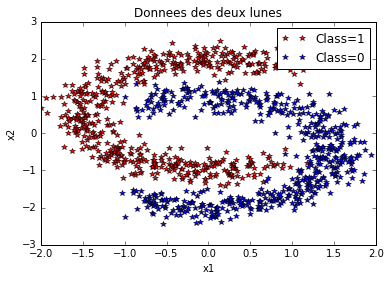

In [8]:
#Question 5 repartitionnement des données pour la suite
data = pd.read_csv('2moons.txt',sep=" ", header = None)

data.drop(3,1,inplace=True) #retire la dernière colonne qui est in end of line mal lu par pandas

data_x = np.array(data[[0,1]][:])
data_y = np.array(data[2][:])
# On sépare l'ensemble en 70% train, 30% valid
train = int(round(len(data)*0.7)+1)
#valid = int(round(len(data)*0.2)+1)+train

#Transformation en ensemble de train, valid, test
#Transforme aussi la variable cible sous forme oneHot
#####################################################
train_x = np.array(data[[0,1]][:train])
train_y_raw = np.array(data[2][:train])
train_y = oneHot(np.array(data[2][:train]))

valid_x = np.array(data[[0,1]][train:])
valid_y_raw = np.array(data[2][train:])
valid_y = oneHot(np.array(data[2][train:]))
#####################################################
#test_x = np.array(data[[0,1]][valid:])
#test_y_raw = np.array(data[2][valid:])
#test_y = oneHot(np.array(data[2][valid:]))
#plt.plot(data[0][np.where(data[2][:] == 1)])
#plt.show()

plt.plot(data[0][np.where(data[2][:] == 1)[0]],data[1][np.where(data[2][:] == 1)[0]],'*r')
plt.plot(data[0][np.where(data[2][:] == 0)[0]],data[1][np.where(data[2][:] == 0)[0]],'*b')
plt.title('Donnees des deux lunes')
plt.ylabel('x2')
plt.xlabel('x1')
plt.legend(['Class=1','Class=0'])
plt.show()

Convergence, minimum possible après 312 itérations.
Erreur de prediction sur train:  21.4007782101 %
Erreur de prediction sur valid:  21.8844984802 %


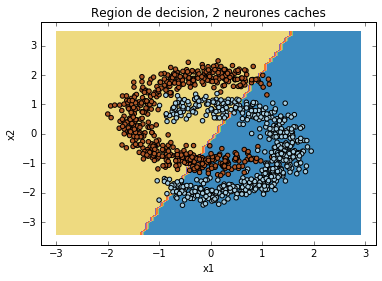

In [9]:
#######################################################
# Question 5, suite
#######################################################
dh = 2 #nombre de neurones cachés
wd = np.array([[0.1,0.5],[0.1,0.5]]) #Weight decay on penalise davantage la norme au carre
max_it = 2000 #nombre maximal d'itérations avant arrêt de la descente de gradient.

#on crée et initialise le réseau de neuronnes
# NeraulNet(self,d,dh,m,nc=1,lam=np.array([[.1,.5],[.1,.5]])):
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
nn.train(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
print 'Erreur de prediction sur train: ', sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,'%'
print 'Erreur de prediction sur valid: ', sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,'%'

nn.plotDecision(data_x, data_y)

#on crée et initialise le réseau de neuronnes
# NeraulNet(self,d,dh,m,nc=1,lam=np.array([[.1,.5],[.1,.5]])):
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
#nn.train_mat(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
#print 'Erreur de prediction sur train: ', sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,'%'
#print 'Erreur de prediction sur valid: ', sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,'%'

#nn.plotDecision(data_x, data_y)

Arrêt causé par nombre d'itérations
Erreur de prediction sur train:  1.94552529183 %
Erreur de prediction sur valid:  1.82370820669 %


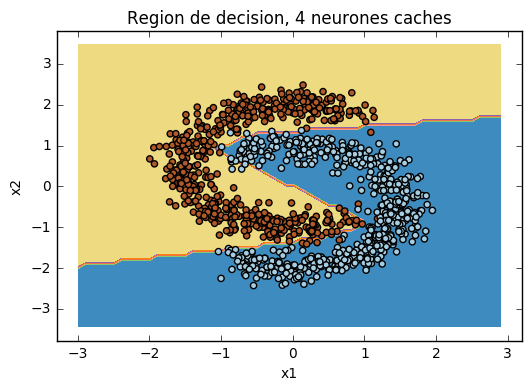

In [311]:
#######################################################
# Question 5, suite
# on modifie le nombre de neurones cachés. On aura donc plus de parametres a estimer
# on conserve le weight decay identique pour mesurer seulement l'impact de dh
#######################################################
dh = 4 #nombre de neurones cachés
wd = np.array([[0.1,0.5],[0.1,0.5]]) #Weight decay on penalise davantage la norme au carre
max_it = 2000 #nombre maximal d'itérations avant arrêt de la descente de gradient.

#on crée et initialise le réseau de neuronnes
# NeraulNet(self,d,dh,m,nc=1,lam=np.array([[.1,.5],[.1,.5]])):
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
nn.train(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
print 'Erreur de prediction sur train: ', round(sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,2),'%'
print 'Erreur de prediction sur valid: ', round(sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,2),'%'
nn.plotDecision(data_x, data_y)

Convergence, minimum possible après 2148 itérations.
Erreur de prediction sur train:  2.07522697795 %
Erreur de prediction sur valid:  1.51975683891 %


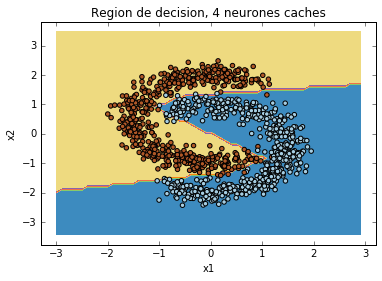

In [10]:
#######################################################
# Question 5, suite
# on modifie le nombre maximal d'itérations
# on conserve le weight decay identique pour mesurer seulement l'impact de max_iter
#######################################################
dh = 4 #nombre de neurones cachés
wd = np.array([[0.1,0.5],[0.1,0.5]]) #Weight decay on penalise davantage la norme au carre
max_it = 5000 #nombre maximal d'itérations avant arrêt de la descente de gradient.

#on crée et initialise le réseau de neuronnes
# NeraulNet(self,d,dh,m,nc=1,lam=np.array([[.1,.5],[.1,.5]])):
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
nn.train(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
print 'Erreur de prediction sur train: ', sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,'%'
print 'Erreur de prediction sur valid: ', sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,'%'
nn.plotDecision(data_x, data_y)

Convergence, minimum possible après 2635 itérations.
Erreur de prediction sur train:  1.94552529183 %
Erreur de prediction sur valid:  3.03951367781 %


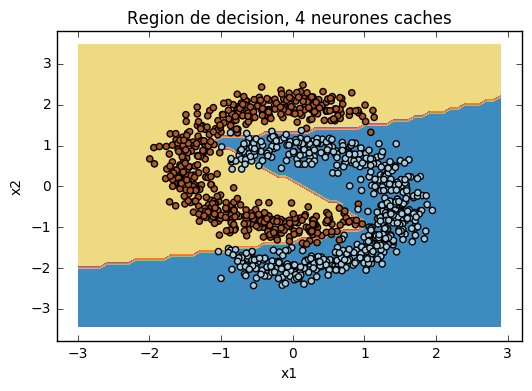

In [314]:
#######################################################
# Question 5, suite
# on modifie la penalite weight decay
# on conserve dh et max_iter identiques pour evaluer le changement causé par les penalités
#######################################################
dh = 4 #nombre de neurones cachés
wd = np.array([[0.3,0.8],[0.3,0.8]]) #Weight decay on penalise davantage la norme au carre
max_it = 5000 #nombre maximal d'itérations avant arrêt de la descente de gradient.

#on crée et initialise le réseau de neuronnes
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
nn.train(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
print 'Erreur de prediction sur train: ', sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,'%'
print 'Erreur de prediction sur valid: ', sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,'%'
nn.plotDecision(data_x, data_y)

Convergence, minimum possible après 2252 itérations.
Erreur de prediction sur train:  0.907911802853 %
Erreur de prediction sur valid:  1.21580547112 %


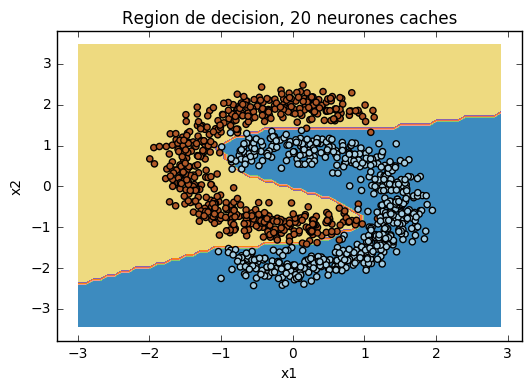

In [14]:
#######################################################
# Question 5, suite
# Dernier essai en modifiant la valeur de dh pour tenter de minimiser le plus possible l'erreur d'entrainement
# max_iter = 10 000 pour eviter tout arret premature
#######################################################
dh = 20 #nombre de neurones cachés
wd = np.array([[0.1,0.5],[0.1,0.5]]) #Weight decay on penalise davantage la norme au carre
max_it = 10000 #nombre maximal d'itérations avant arrêt de la descente de gradient.

#on crée et initialise le réseau de neuronnes
nn = NeuralNet(2,dh,2,lam=wd)
nn.initialisation()
#on entraîne sur les exemples de l'ensemble de train des données
nn.train(train_x,train_y,L=0.1,precision=0.001,k=train_x.shape[0],max_iter=max_it)
print 'Erreur de prediction sur train: ', sum(nn.predict(train_x)!=train_y_raw)*1./train_x.shape[0]*100.,'%'
print 'Erreur de prediction sur valid: ', sum(nn.predict(valid_x)!=valid_y_raw)*1./valid_x.shape[0]*100.,'%'
nn.plotDecision(data_x, data_y)

In [15]:
#################################################
#Question 7 (implementation de la question 6 dans la classe NeuralNet(fprop_mat, bprop_mat, train_mat))
#################################################
# pour k = 1
x=train_x[2]
y=train_y_raw[2]

#Question 1
nn = NeuralNet(2,1,2)
nn.initialisation()
# entraine par descente de gradient avec boucle
nn.train(x,y)
grad_old = nn.grad.copy()
#entrain par descentes de gradient matricielle
nn2 = NeuralNet(2,1,2)
nn2.initialisation()
nn2.train_mat(x,y)
grad_new = nn2.grad.copy()
#######################################
# on imprime grad_old - grad_new
######################################
diff = grad_old - grad_new
print 'La difference de gradient pour chaque parametre pour k = 1:\n',np.around(diff,2)

#################################################
#Question 7 (implementation de la question 6 dans la classe NeuralNet(fprop_mat, bprop_mat, train_mat))
#################################################
# pour k = 10
x=train_x[:10]
y=train_y_raw[:10]

#Question 1
nn = NeuralNet(2,2,2)
nn.initialisation()
# entraine par descente de gradient avec boucle
nn.train(x,y,k=10)
grad_old = nn.grad.copy()

#entraine par descentes de gradient matricielle
nn2 = NeuralNet(2,2,2)
nn2.initialisation()
nn2.train_mat(x,y,k=10)
grad_new = nn2.grad.copy()
#######################################
# on imprime grad_old - grad_new
######################################
diff = grad_old - grad_new
print 'La difference de gradient pour chaque parametre pour k = 10:\n',np.around(diff,2)


Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
La difference de gradient pour chaque parametre pour k = 1:
[ 0.  0.  0.  0.  0.  0.  0.]
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
La difference de gradient pour chaque parametre pour k = 10:
[ -1.06681004e+78   1.54335915e+79   2.17272676e+44  -1.26518113e+45
   8.84801780e+78   3.17874554e+44  -6.11825182e+78  -3.02706432e+45
   3.23285438e+79   1.08643386e+45  -4.49000000e+00   5.49000000e+00]


In [16]:
import gzip,pickle
f=gzip.open('mnist.pkl.gz')
data=pickle.load(f)

#images de 28x28 pixels = vecteur de 784 features
# train possede 50 000 observations, 784 features et 10 classes
train_x = data[0][0] # matrice de train data
train_y_raw = data[0][1] # vecteur des train labels
train_y = oneHot(train_y_raw)
# valid possede 10 000 observations, 784 features et 10 classes
valid_x = data[1][0] # matrice de valid data
valid_y_raw = data[1][1] # vecteur des valid labels
valid_y = oneHot(valid_y_raw)

# test possede 10 000 observations, 784 features et 10 classes
test_x = data[2][0] # matrice de test data
test_y_raw = data[2][1] # vecteur des test labels
test_y = oneHot(test_y_raw)

In [149]:
##########################################
# DO NOT RUN !!!!!!!!!!!!!!!!!!!!!!!!!!!!!
##########################################
# Question 8 (boucle)
# Prend près de 4h à rouler sur CPU Intel i7-4710 HQ
##########################################
import time
##########################################
#parametres:
dh = 20
d = train_x.shape[1]
m = train_y.shape[1]
maxit = 2500
k = 100
##########################################
# entrainement par boucle
##########################################
nn_loop = NeuralNet(d,dh,m)
nn_loop.initialisation()
start_time = time.time()
for i in range(0,train_x.shape[0]-k,k):
    x = train_x[i:i+k]
    y = train_y[i:i+k]
    nn_loop.train(x,y,k=100,max_iter=maxit)
    
print("Time for 1 epoch using loops : %s seconds ---" % (time.time() - start_time))

Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Convergence, minimum possible après 2304 itérations.
Convergence, minimum possible après 1889 itérations.
Convergence, minimum possible après 1838 itérations.
Convergence, minimum possible après 1482 itérations.
Convergence, minimum possible après 1988 itérations.
Convergence, minimum possible après 1554 itérations.
Convergence, minimum possible après 1696 itérations.
Convergence, minimum possible après 2085 itérations.
Convergence, minimum possible après 

In [181]:
# temps total entrainement en boucle: 13816.505 secondes = 3.83 heures = 3h48 minutes

In [153]:
##########################################
# Question 8 (matrice)
# Prend près de 12 min a rouler
##########################################
import time
##########################################
#parametres:
dh = 20
d = train_x.shape[1]
m = train_y.shape[1]
maxit = 2500
k = 100
##########################################
# entrainement par formulation matricielle
##########################################
nn_mat = NeuralNet(d,dh,m)
nn_mat.initialisation()
start_time = time.time()
for i in range(0,train_x.shape[0]-k,k):
    x = train_x[i:i+k]
    y = train_y[i:i+k]
    nn_mat.train_mat(x,y,k=100,max_iter=maxit)
    
print("Time for 1 epoch using loops : %s seconds ---" % (time.time() - start_time))

Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Convergence, minimum possible après 2417 itérations.
Convergence, minimum possible après 2137 itérations.
Arrêt causé par nombre d'itérations
Convergence, minimum possible après 2425 itérations.
Convergence, minimum possible après 1844 itérations.
Convergence, minimum possible après 1900 itérations.
Convergence, minimum possible après 2278 itérations.
Convergence, minimum possible après 2238 itérations.
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Convergence, mini

In [182]:
# temps total entrainement (1 epoch) en matrices: 713.28 secondes = 11 minutes 53.28 secondes
print 'Entrainement en boucle est ', round(13816.5/713.3,2),' fois plus long que par matrice....'

Entrainement en boucle est  19.37  fois plus long que par matrice....


In [180]:
##########################################
# Question 9 
##########################################
# En entraine sur 20 epoch, un reseau a 200 neuronnes caches
#########################################
import csv
#########################################
n_epoch = 10
dh = 200
d = train_x.shape[1]
m = train_y.shape[1]
maxit = 2500
k = 500
#########################################
final_network = NeuralNet(d,dh,m)
final_network.initialisation()
#########################################
fieldnames = ['Epoch','Train_err','Valid_err','Test_err','Train_loss','Valid_loss','Test_loss']
# Début de l'entraînement
with open('results.csv', 'wb') as csvfile:
    resWriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
    resWriter.writerow(fieldnames)
    #on entraine sur le nb d'epoch specifie
    for epoch in range(1,n_epoch+1):
        #on parcours tous les lots avec k obs par mini lot
        for i in range(0,train_x.shape[0]-k,k):
            if i + k == train_x.shape[0]:
                x = train_x[i:]
                y = train_y[i:]
            else:
                x = train_x[i:i+k]
                y = train_y[i:i+k]
            
            final_network.train_mat(x,y,k=500,max_iter=maxit,print_res=False) #on nimprime pas les resultats de l<optimisation
            
        
        #Calcul des predictions a la fin de chaque Epoch
        pred_train = final_network.predict(train_x)
        pred_valid = final_network.predict(valid_x)
        pred_test = final_network.predict(test_x)
        
        #Calcul des erreurs de prediction a la fin de chaque Epoch
        train_err = sum(pred_train!=train_y_raw)*1./train_x.shape[0]
        valid_err = sum(pred_valid!=valid_y_raw)*1./valid_x.shape[0]
        test_err = sum(pred_test!=test_y_raw)*1./test_x.shape[0]
            
        #calcul du cout moyen a la fin de chaque Epoch
        train_loss = (1./train_x.shape[0])* np.sum(-np.log(np.dot(final_network.get_prob_mat(train_x).T,train_y)))
        valid_loss = (1./valid_x.shape[0])* np.sum(-np.log(np.dot(final_network.get_prob_mat(valid_x).T,valid_y)))
        test_loss  = (1./test_x.shape[0])* np.sum(-np.log(np.dot(final_network.get_prob_mat(test_x).T,test_y))) 
        
        print 'Epoch: ', epoch,'/',n_epoch
        print '#########################################################################'
        print 'Erreur de prediction sur train: ', round(train_err,2)*100.,'%'
        print 'Erreur de prediction sur valid: ', round(valid_err,2)*100.,'%'
        print 'Erreur de prediction sur valid: ', round(test_err,2)*100.,'%' 
        print 'Coût moyen sur train: ', train_loss
        print 'Coût moyen sur valid: ', valid_loss
        print 'Coût moyen sur test: ', test_loss
        print '#########################################################################'
        resWriter.writerow([epoch, train_err, valid_err, test_err, train_loss, valid_loss, test_loss])

Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Arrêt causé par nombre d'itérations
Convergence, minimum possible après 2400 itérations.


KeyboardInterrupt: 